<a href="https://colab.research.google.com/github/thunwaaa/sign_language/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe opencv-python numpy

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [3]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

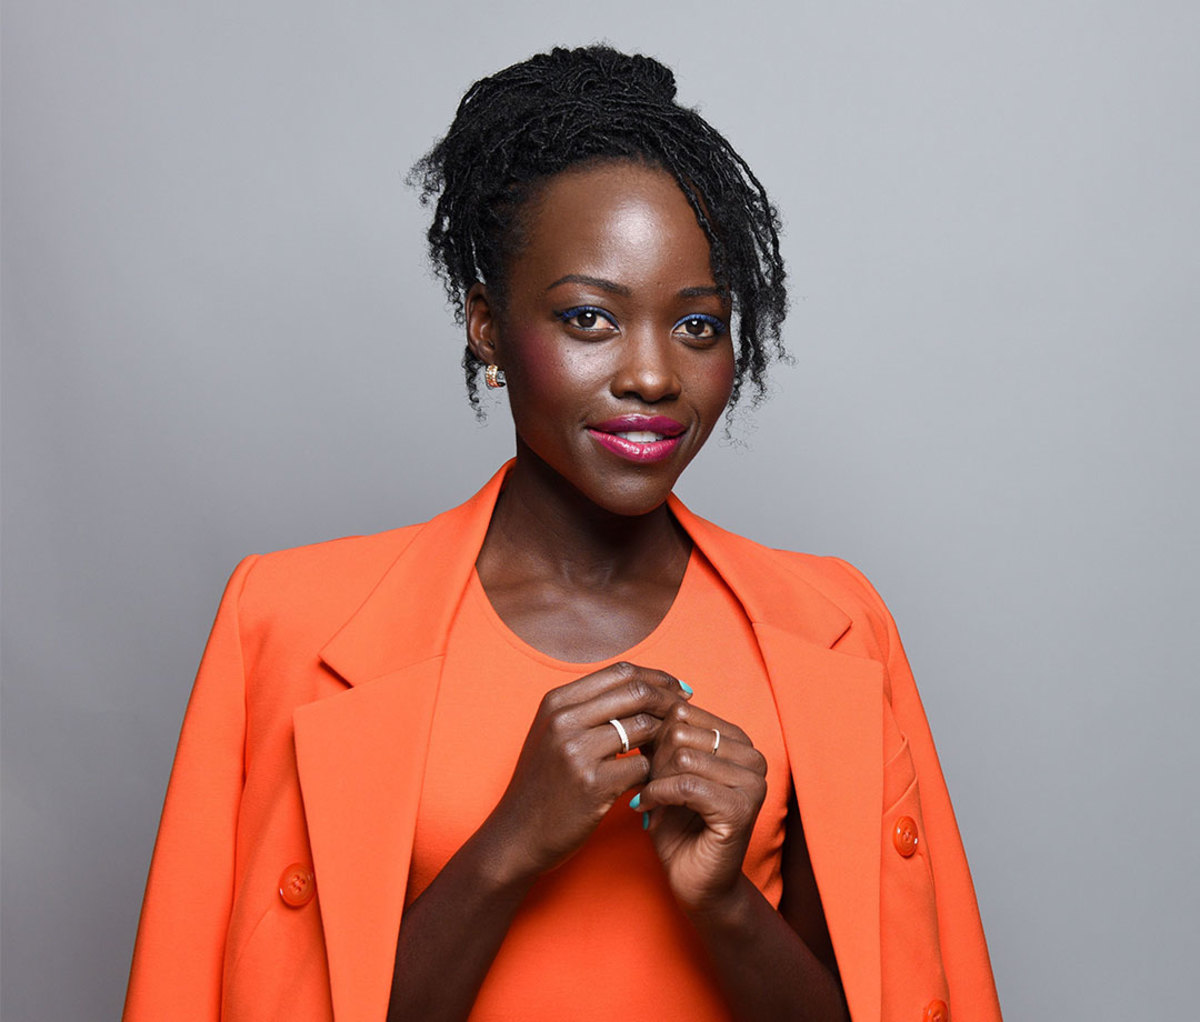

In [8]:
#

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [4]:
# โค้ดสำหรับอัปโหลดวิดีโอใน Google Colab
import cv2
import mediapipe as mp
import numpy as np
import time
import os

from google.colab import files
uploaded = files.upload()  # อัปโหลดวิดีโอของคุณ

# เก็บชื่อไฟล์ที่อัปโหลด
input_video_path = list(uploaded.keys())[0]
print(f"Uploaded: {input_video_path}")

output_video_path = "output_hand_detection.mp4"

Saving 1.2.1.mp4 to 1.2.1 (2).mp4
Uploaded: 1.2.1 (2).mp4


## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


In [5]:
import cv2
import mediapipe as mp
import numpy as np
import time
import os
import urllib.request

# MediaPipe initialization
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode
options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2)

# Open the video file
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {input_video_path}")
    exit()

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Create video writer for output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

with HandLandmarker.create_from_options(options) as landmarker:
    # Initialize timestamp
    timestamp = 0
    frame_count = 0

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            print("End of video or error reading frame.")
            break

        frame_count += 1
        # Optional: Print progress
        if frame_count % 10 == 0:
            print(f"Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

        # Convert to RGB (MediaPipe requirement)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

        # Process the frame
        results = landmarker.detect_for_video(mp_image, timestamp)
        timestamp += 1

        # Draw hand landmarks
        if results.hand_landmarks:
            for idx, hand_landmarks in enumerate(results.hand_landmarks):
                # Get hand label (LEFT or RIGHT)
                handedness = results.handedness[idx][0].category_name

                # Get center of hand for text placement
                x_values = [landmark.x for landmark in hand_landmarks]
                y_values = [landmark.y for landmark in hand_landmarks]
                center_x = int(sum(x_values) / len(x_values) * frame.shape[1])
                center_y = int(sum(y_values) / len(y_values) * frame.shape[0])

                # Draw connections
                for connection in mp.solutions.hands.HAND_CONNECTIONS:
                    start_idx = connection[0]
                    end_idx = connection[1]

                    start_point = (int(hand_landmarks[start_idx].x * frame.shape[1]),
                                  int(hand_landmarks[start_idx].y * frame.shape[0]))
                    end_point = (int(hand_landmarks[end_idx].x * frame.shape[1]),
                                int(hand_landmarks[end_idx].y * frame.shape[0]))

                    cv2.line(frame, start_point, end_point, (0, 255, 0), 2)

                # Draw landmarks
                for landmark in hand_landmarks:
                    landmark_point = (int(landmark.x * frame.shape[1]),
                                     int(landmark.y * frame.shape[0]))
                    cv2.circle(frame, landmark_point, 5, (255, 0, 0), -1)

                # Display hand label
                color = (255, 0, 0) if handedness == "LEFT" else (0, 0, 255)
                text_position = (center_x, center_y - 30)
                cv2.putText(frame, handedness, text_position,
                           cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Write the frame to output video
        out.write(frame)

        # Optional: Display the frame (comment out for faster processing)
        # cv2.imshow('Processing Video', frame)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Processing complete. Output saved to {output_video_path}")

files.download(output_video_path)

Processing frame 10/217 (4.6%)
Processing frame 20/217 (9.2%)
Processing frame 30/217 (13.8%)
Processing frame 40/217 (18.4%)
Processing frame 50/217 (23.0%)
Processing frame 60/217 (27.6%)
Processing frame 70/217 (32.3%)
Processing frame 80/217 (36.9%)
Processing frame 90/217 (41.5%)
Processing frame 100/217 (46.1%)
Processing frame 110/217 (50.7%)
Processing frame 120/217 (55.3%)
Processing frame 130/217 (59.9%)
Processing frame 140/217 (64.5%)
Processing frame 150/217 (69.1%)
Processing frame 160/217 (73.7%)
Processing frame 170/217 (78.3%)
Processing frame 180/217 (82.9%)
Processing frame 190/217 (87.6%)
Processing frame 200/217 (92.2%)
Processing frame 210/217 (96.8%)
End of video or error reading frame.
Processing complete. Output saved to output_hand_detection.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>